<a href="https://colab.research.google.com/github/Apekshagaonkar/dl_covid/blob/main/0_Dataset_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Covid19AI"

/content/drive/My Drive/Covid19AI


In [ ]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/BEASF.py" .

In [ ]:
!cp "/content/drive/My Drive/Covid19AI/Jupyter_notebooks/visualization_tools.py" .

In [ ]:
!pip3 install lime

     |████████████████████████████████| 276kB 8.0MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=127a1d0d0a444543302f242dd9156ca9259d97f7806973e175e88efb1e990fd8
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import glob, numpy as np, cv2, matplotlib.pyplot as plt, copy, tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import Model, callbacks as cb, optimizers
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Conv2D, Conv2DTranspose, concatenate, MaxPooling2D
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from skimage.filters import rank
from skimage.morphology import disk

from BEASF import BEASF
from visualization_tools import GradCAM

# read Data and convert to npy

In [ ]:
def get_images(img_path):
  normal_images = list()
  cap_images = list()
  other_images = list()
  # covid_images = list()
  for img_name in glob.glob(pathname=img_path + '/*'):
    img = load_img(path=img_name, color_mode='grayscale')
    img = img_to_array(img=img, data_format='channels_last')
    # if 'COVID' in img_name:
      # covid_images.append(img)
    if  'other' in img_name:
        other_images.append(img)
    elif 'pneumonia' in img_name:
      cap_images.append(img)
    elif 'normal' in img_name:
      normal_images.append(img)
  normal_images = np.array(normal_images)
  cap_images = np.array(normal_images)
  #covid_images = np.array(normal_images)
  other_images = np.array(normal_images)

  normal_labels = [0 for _ in range(len(normal_images))]
  cap_labels = [1 for _ in range(len(cap_images))]
  #covid_labels = [2 for _ in range(len(covid_images))]
  other_labels = [2 for _ in range(len(other_images))]

  X = np.concatenate((other_images, cap_images, normal_images))
  y = np.array(other_labels + cap_labels + normal_labels)
  return X,y

In [ ]:
def resize_images_of(X):
    X = np.array([cv2.resize(image, dsize=(320, 320), interpolation=cv2.INTER_CUBIC) for image in X])
    X = np.array([np.expand_dims(a=image, axis=-1) for image in X])
    X = X.astype(dtype=np.uint8)
    return X


def show_random_image_from(X):
    rnd_idx = np.random.choice(a=len(X), size=None)
    plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(label='a random image from the dataset')
    plt.show()


def save_dataset(data, labels):
    print('number of total dataset images:', len(data))
    print('number of total dataset labels:', len(labels))
    print('dataset shape:', data.shape)
    print("export images as npy file? (y/n) : default = n need to remove commented code if needed to export")
    """
    if input() == 'y':
        np.save('./covid_cxr_dataset/cxr_samples.npy', arr=data)
        np.save('./covid_cxr_dataset/cxr_labels.npy', arr=labels)
        print(labels)
    else:
        print('dataset exportation aborted.')"""
    np.save('./covid_cxr_dataset/cxr_samples.npy', arr=data)
    np.save('./covid_cxr_dataset/cxr_labels.npy', arr=labels)
    print(labels)
    print('saved as ./covid_cxr_dataset/cxr_samples.npy')
    print('saved as ./covid_cxr_dataset/cxr_labels.npy')

In [ ]:
!ls

In [ ]:
data_path = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/training '

#X,y = get_images(img_path=data_path)
#X = resize_images_of(X=X)
#show_random_image_from(X=X)
#save_dataset(data=X, labels=y)

In [ ]:
p2c = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS'
p2p = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA'
p2n = '/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL'
 

In [ ]:
i=0
other_images = list()
for img_name in glob.glob(pathname=p2c + '/*'):
        print(img_name)
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        other_images.append(img)
        i = i+1
        if i == 501: 
          break

/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (200).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (190).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1892).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1920).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1908).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (195).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1901).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1888).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1996).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (196).png
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/OTHERS/TB (1903).png
/content/drive/My Drive/Covid19AI/covid_cxr_dat

In [ ]:
len(other_images)

501

In [ ]:
i=0
cap_images = list()
for img_name in glob.glob(pathname=p2p + '/*'):
        print(img_name)
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        cap_images.append(img)
        i = i+1
        if i==501:
          break

/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/276.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/299.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/272.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/243.jfif
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/371.jfif
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/316.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/305.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/256.jfif
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/227.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/297.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMONIA/357.jpg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/PNEUMON

In [ ]:
len(cap_images)

501

In [ ]:
i=0
normal_images = list()
for img_name in glob.glob(pathname=p2n + '/*'):
        print(img_name)
        img = load_img(path=img_name, color_mode='grayscale')
        img = img_to_array(img=img, data_format='channels_last')
        normal_images.append(img)
        i = i + 1
        if i == 501:
          break

/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0519-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0520-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0521-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0531-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0530-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0533-0001-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0532-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0525-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0528-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0534-0001.jpeg
/content/drive/My Drive/Covid19AI/covid_cxr_dataset/Training_data/NORMAL/IM-0526-0001

In [ ]:
normal_images = np.array(normal_images)
cap_images    = np.array(cap_images)
other_images  = np.array(other_images)

normal_labels = [0 for _ in range(len(normal_images))]
cap_labels    = [1 for _ in range(len(cap_images))]
other_labels  = [2 for _ in range(len(other_images))]

X = np.concatenate((other_images, cap_images, normal_images))
y = np.array(other_labels + cap_labels + normal_labels)

print(y)

[2 2 2 ... 0 0 0]


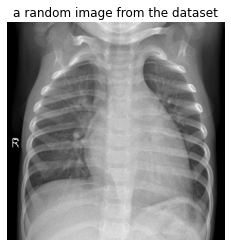

number of total dataset images: 1503
number of total dataset labels: 1503
dataset shape: (1503, 320, 320, 1)
export images as npy file? (y/n) : default = n need to remove commented code if needed to export
[2 2 2 ... 0 0 0]
saved as ./covid_cxr_dataset/cxr_samples.npy
saved as ./covid_cxr_dataset/cxr_labels.npy


In [ ]:
X = resize_images_of(X=X)
show_random_image_from(X=X)
save_dataset(data=X, labels=y)

# Verifying the dataset preperation

number of total dataset images: 1503
number of total dataset labels: 1503
dataset shape: (1503, 320, 320, 1)


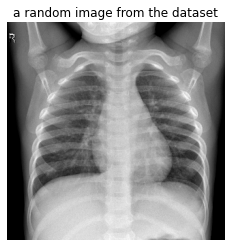

In [ ]:
X = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_samples.npy',allow_pickle=True)
y = np.load(file='/content/drive/My Drive/Covid19AI/covid_cxr_dataset/cxr_labels.npy',allow_pickle=True)

print('number of total dataset images:', len(X))
print('number of total dataset labels:', len(y))
print('dataset shape:', X.shape)

rnd_idx = np.random.choice(a=len(X), size=None)
plt.imshow(X=X[rnd_idx].squeeze(), cmap='gray')
plt.axis('off')
plt.title(label='a random image from the dataset')
plt.show()

In [ ]:
print(y)

[2 2 2 ... 0 0 0]
